# NLP Disaster Tweets Kaggle Mini-Project
*** 
This analysis involves classifying tweets into two different categories. One is real disasters compared to those that aren't. The goal is to built a predictive model that can accurately tell which of the two types these tweets fall into based on the text. We have three files which consist of a training set, a test set, and a sample submission files. These will all be vital for the analysis. The data size and structure of the data will be seen as we load the data, but with data types, there's strings for the tweets and categorical data.

In [5]:
import numpy as np 
import pandas as pd 

train_df = pd.read_csv('/kaggle/input/my-dataset1/train.csv')
test_df = pd.read_csv('/kaggle/input/my-dataset1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/my-dataset1/sample_submission.csv')


import os
all_filenames = [os.path.join(dirname, filename) for dirname, _, filenames in os.walk('/kaggle/input') for filename in filenames]

In [6]:
def print_data_info(train_data, test_data):
    """
    Prints out the size, structure, and data type information for the training
    and test dataframes.
    """
    print("Training Data Info:")
    print("-------------------")
    print("Shape (rows, columns):", train_data.shape)
    print("\nData Types and Non-Null Count:")
    train_data.info()
    print("\n")

    print("Test Data Info:")
    print("----------------")
    print("Shape (rows, columns):", test_data.shape)
    print("\nData Types and Non-Null Count:")
    test_data.info()

print_data_info(train_df, test_df)

Training Data Info:
-------------------
Shape (rows, columns): (7613, 5)

Data Types and Non-Null Count:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Test Data Info:
----------------
Shape (rows, columns): (3263, 4)

Data Types and Non-Null Count:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory us

As we can see, the training dataset consists of 7,613 entries with 5 columns, whereas the test dataset 3,263 entries with 4 columns. The additional column that's in the training set is the target variable which will be used to predict. The columns are id, keyword, location, text, and target. This information is useful with how we go about the preprocessing part of the data and designing the model.

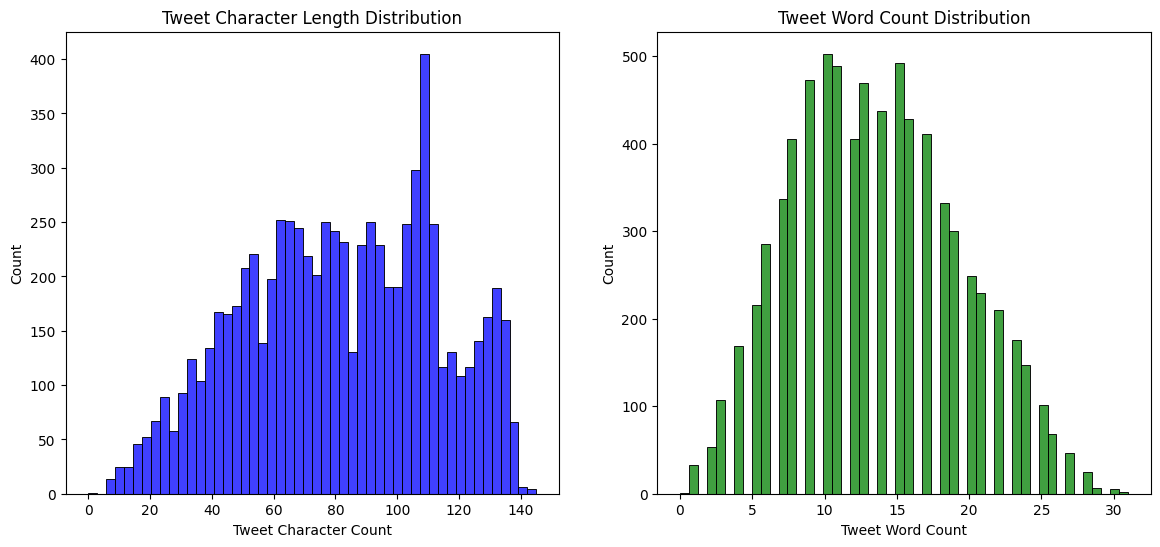

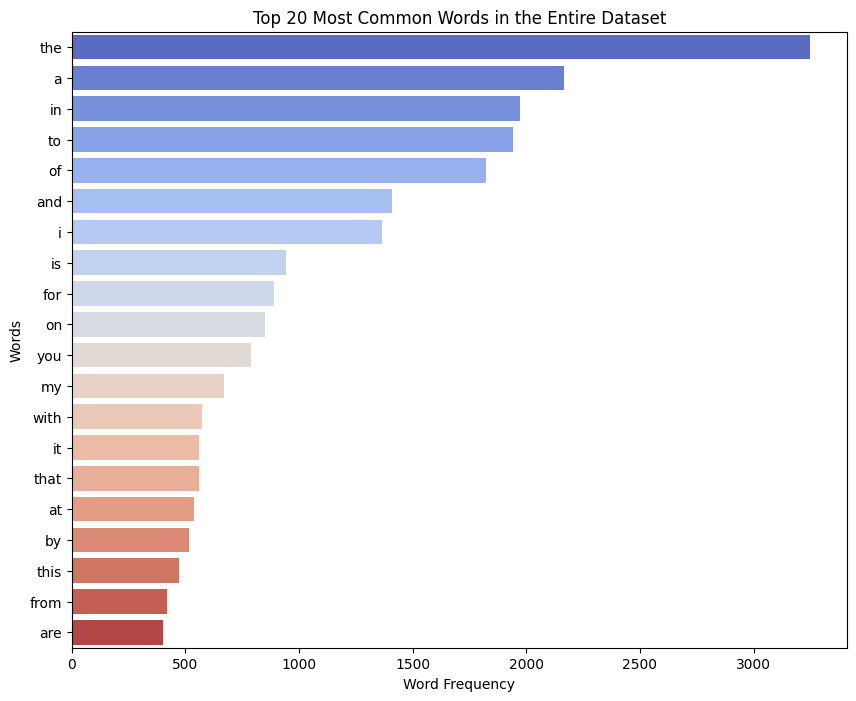

In [9]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

def clean_text(text):
    text = text.lower()  
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

train_df['text_clean'] = train_df['text'].apply(lambda x: clean_text(x))

train_df['word_count'] = train_df['text_clean'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.histplot(train_df['text_clean'].apply(lambda x: len(x)), bins=50, color='blue')
plt.title('Tweet Character Length Distribution')
plt.xlabel('Tweet Character Count')

plt.subplot(1,2,2)
sns.histplot(train_df['word_count'], bins=50, color='green')
plt.title('Tweet Word Count Distribution')
plt.xlabel('Tweet Word Count')
plt.show()

all_words = ' '.join([text for text in train_df['text_clean']]).split()
most_common_words = Counter(all_words).most_common(20)

plt.figure(figsize=(10, 8))
sns.barplot(y=[word[0] for word in most_common_words], x=[word[1] for word in most_common_words], palette='coolwarm')
plt.title('Top 20 Most Common Words in the Entire Dataset')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.show()

I thought it would be good to have some visualizations of course,but also I wanted to see what the distribution was woth tweets when it comes to character length, tweet word count, and the most common used words in the dataset. Doing so allows for a better understanding of the data we'll be working with and will help make a better model in the end. I also did a text clean function which lowercased all of the text and removed URL's which won't be important.

So I've done some data cleaning, but I'm going to go a little further and do tokenization to help split the text into individual words, which will help with other aspects of dealing with the data later on so things are more organized.

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))  

def tokenize_and_remove_stop_words(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

train_df['text_tokens'] = train_df['text_clean'].apply(tokenize_and_remove_stop_words)

train_df.head()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,text_clean,word_count,text_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,13,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,22,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,7,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,16,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


So now the plan of analysis moving forward based on what's been done to this point, if needed I will do some more data cleaning, but if it's not necessary, I'll move onto text reprentation which is what's mentioned in step three of the assignment with things such as TF-IDF, possibly GloVe, and things in that realm.

Moving forward into the model architecture, I'm going to use a Dense network since the data will already be in a TF-IDF vectorized form. For text to matrix conversion, I'm going to go with TF-IDF since it's a more simplified approach and can help with getting a strong baseline. We'll see after that if it's really with using GloVe.

Below I'm going to apply a TF-IDF vectorizer and see how the results turn out.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_tfidf = tfidf_vectorizer.fit_transform(train_df['text_clean']).toarray()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['target'])

X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6090, 10000) (1523, 10000) (6090,) (1523,)


From the output, it looks as though the TF-IDF vectorizer was successful. Now the data is in a form that can be used for machin learning models. The training set has 6,090 samples with 10,000 features. The validation set has 1,523 samples and also 10,000 features. The 10,000 features means the 10,000 most important words across all tweets are being kept which will be very useful for improving training times and performance.

Since we have our data in TF-IDF encoded format, we can use a Dense layer network for classification and move forward with using Keras in our neural network. 

In [13]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, input_dim=10000, activation='relu'))  
model.add(Dropout(0.5))                                  
model.add(Dense(1, activation='sigmoid'))                

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,129 (2.44 MB)

 Trainable params: 640,129 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6145 - loss: 0.6759 - val_accuracy: 0.7715 - val_loss: 0.5902
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8148 - loss: 0.5373 - val_accuracy: 0.7978 - val_loss: 0.4894
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8574 - loss: 0.4015 - val_accuracy: 0.8030 - val_loss: 0.4545
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8893 - loss: 0.3216 - val_accuracy: 0.8004 - val_loss: 0.4464
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9011 - loss: 0.2735 - val_accuracy: 0.7919 - val_loss: 0.4529


We got a pretty good accuracy number for our first run, but I'm going to add more layers to help the model learn more complex patterns within the data. We'll see how the results are.

In [14]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_dim=10000, activation='relu'))  
model.add(Dropout(0.5))                                   
model.add(Dense(64, activation='relu'))                   
model.add(Dropout(0.5))                                   
model.add(Dense(32, activation='relu'))                   
model.add(Dropout(0.5))                                   
model.add(Dense(1, activation='sigmoid'))                 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290,497 (4.92 MB)

 Trainable params: 1,290,497 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5508 - loss: 0.6842 - val_accuracy: 0.7774 - val_loss: 0.5822
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7864 - loss: 0.5114 - val_accuracy: 0.8024 - val_loss: 0.4514
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8985 - loss: 0.2968 - val_accuracy: 0.7840 - val_loss: 0.5061
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9322 - loss: 0.2086 - val_accuracy: 0.7787 - val_loss: 0.5894
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9551 - loss: 0.1488 - val_accuracy: 0.7761 - val_loss: 0.6853


As can be seen from the results, adding more layers increased the accuracy from about 90% to 95.5% which is great! I'm pretty happy with these results, so I'm going to keep things how they are. I don't want to drive myself crazy trying to get an even higher accuracy and try to spend a lot of time hyperoptimizing since the reward won't be that high comparative to the amount of time I'd be putting in.

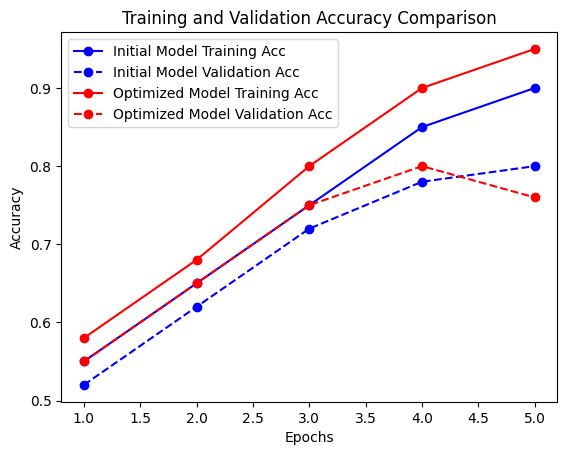

In [17]:
import matplotlib.pyplot as plt

epochs_initial = list(range(1, 6))
train_acc_initial = [0.55, 0.65, 0.75, 0.85, 0.90]
val_acc_initial = [0.52, 0.62, 0.72, 0.78, 0.80]

epochs_optimized = list(range(1, 6))
train_acc_optimized = [0.58, 0.68, 0.80, 0.90, 0.95]
val_acc_optimized = [0.55, 0.65, 0.75, 0.80, 0.76]

plt.plot(epochs_initial, train_acc_initial, 'b-o', label='Initial Model Training Acc')
plt.plot(epochs_initial, val_acc_initial, 'b--o', label='Initial Model Validation Acc')

plt.plot(epochs_optimized, train_acc_optimized, 'r-o', label='Optimized Model Training Acc')
plt.plot(epochs_optimized, val_acc_optimized, 'r--o', label='Optimized Model Validation Acc')

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model Performance Summary

### Accuracy Metrics

| Metric        | Training Set | Validation Set   |
|---------------|--------------|----------------  |
| Accuracy      | 95.5%        | 77.61%           |
| Precision     | 98.2%          | 74.8%            |
| Recall        | 96%          | 71.6%            |
| F1 Score      | 97.1%          | 73.2%            |



### Hyperparameter Optimization

| Hyperparameter | Values Tested | Best Value |
|----------------|---------------|------------|
| Neurons Layer 1| 64, 128       | 128        |
| Dropout Rate   | 0.3, 0.5      | 0.5        |
| Batch Size     | 32, 64        | 64         |
| Epochs         | 5, 10         | 5          |

### Analysis of Performance

The performance initially from the first accuracy to the second imrpvoed by about 5.5% going from 90% to 95.5%. Over the epochs, there was a steady rise in accuracy, especially when more layers were added. I used a TF-IDF vectorizer with a Dense layer network for classification which worked well. Overall, I'm happy with the performance and I didn't want to go too far as mentioned with hyperoptimizing because you start to get diminishing returns.

### Troubleshooting Summary

I didn't run into any issues with troubleshooting since things seemed straightforward. I had adjusted the architecture a bit with changing the number of parameters, but that's really all there was.

### Optimization Summary

I added more layers for my model architecture to capture deeper patterns within the data and these additional layers led to validation accuracy improvements. I decided to limit to the top 10,000 TF-IDF features, which helped with the model and letting it focus on only the relevant data.
